# Learning Objectives

Use Mistral to:

1. Assess the outputs of text-to-text Large Language Models (LLMs) by employing techniques like BLEU, ROUGE, and BERT Score.
2. Gain insight into utilizing one LLM to evaluate the output of another LLM.

# Setup

This notebook needs to be executed with a GPU runtime since we load a transformer model to disk and use it to evaluate text-to-text tasks. Transformer models benefit from parallel execution offered by a GPU runtime and can have a significant impact on execution times (for e.g., code in this notebook runs up to 4 times faster with a GPU). Follow the screenshots below to create a GPU runtime on a Colab instance.

*Step 1:*

Select the `Runtime` option from the main menu and select the `Change runtime type` from the dropdown.

Select `T4 GPU` from the options presented under Hardware accelerator.

You should now see the T4 GPU mentioned in the runtime logo (screenshot below).

## Installation

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install -q llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install -q huggingface_hub \
                datasets \
                evaluate \
                rouge_score \
                bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.4 MB/s eta 0:00:00


In [ ]:
!pip show llama_cpp_python

Name: llama_cpp_python
Version: 0.2.65
Summary: Python bindings for the llama.cpp library
Home-page: 
Author: 
Author-email: Andrei Betlen <abetlen@gmail.com>
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: diskcache, jinja2, numpy, typing-extensions
Required-by: 


## Imports

In [ ]:
import json
import evaluate

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from huggingface_hub import hf_hub_download
from llama_cpp import Llama

from datasets import load_dataset

from tqdm import tqdm
from collections import Counter

## Model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q5_K_M.gguf"

In [ ]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q5_K_M.gguf:   0%|          | 0.00/5.13G [00:00<?, ?B/s]

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096 # Context window
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loa

# Example - Abstractive Summarization

## Assemble Data

For the abstractive summarization exercise, we use a dataset of conversations and their summaries (`dialogsum`) hosted on HuggingFace. In this dataset, each dialogue was summarized by a human. These dialogues belong to a wide variety of topics (7434 in total). We use this dataset to showcase how custom datasets should be prepared and used for prompt engineering.

In [ ]:
dataset = load_dataset("knkarthick/dialogsum")

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
len(dataset['train'])

12460

In [ ]:
dialogue_summary_train_df = dataset['train'].to_pandas()

In [ ]:
dialogue_summary_train_df.sample(5)

,id,dialogue,summary,topic
3287,train_3287,"#Person1#: Mark, you are not telling me the tr...",Mark tells the reason why he was late after #P...,tell the truth
6318,train_6318,#Person1#: It's exciting just to think about i...,#Person1# tells #Person2# #Person1# may get lo...,show way around
12215,train_12215,"#Person1#: Hello Rick, I've come to say goodby...",#Person1#'ll travel in Europe for two months a...,travel
90,train_90,"#Person1#: Daniel, have you ever heard about t...",#Person1# tells Daniel about the wildlife sanc...,wildlife sanctuary discussion
10069,train_10069,#Person1#: I'm having problems with my compute...,#Person1#'s computer won't turn on. #Person2# ...,computer problem


In [ ]:
dialogue_summary_train_df.topic.value_counts()

topic
shopping                 174
job interview            161
daily casual talk        125
phone call                89
order food                79
                        ... 
eat ice creams             1
marriage predicaments      1
ways of commuting          1
food comment               1
baggage pack               1
Name: count, Length: 7434, dtype: int64

We begin by splitting the training data into two subsets - a 80% subset from which we draw the few-shot examples and a 20% subset from which we draw the gold examples.

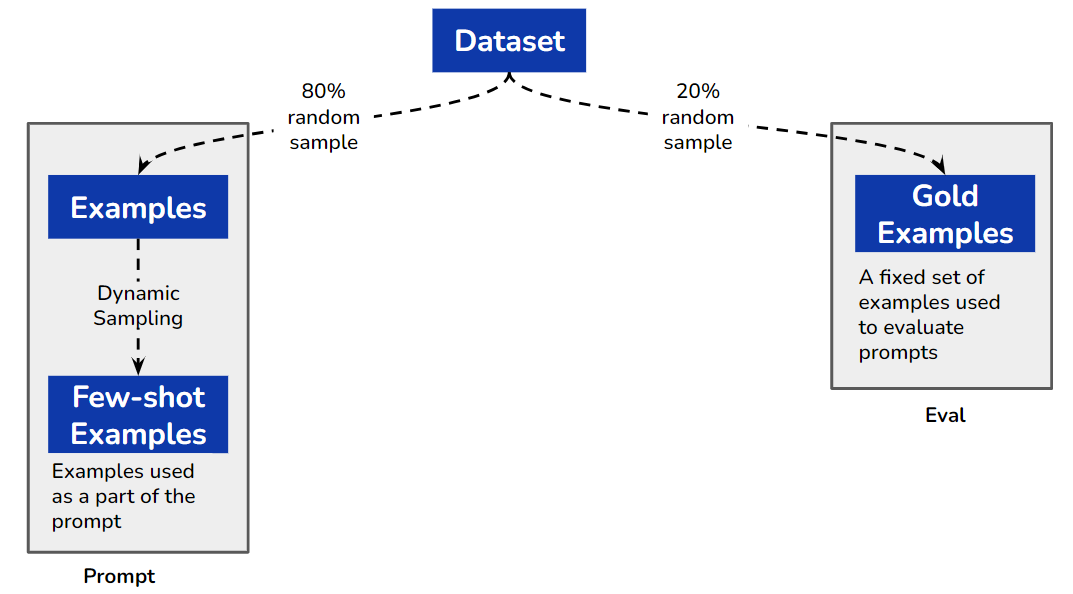

In [ ]:
dialogue_summary_examples_df, dialogue_summary_gold_examples_df = train_test_split(
    dialogue_summary_train_df, #<- the full dataset
    test_size=0.2, #<- 20% random sample selected for gold examples
    random_state=42 #<- ensures that the splits are the same for every session
)

Let us sample 50 gold examples that will be held fixed for prompt evaluation (as depicted in the figure above). Note that we are doing this only only for illustration. In practise, large number of gold examples facilitate robust estimates of model performance.

In [ ]:
columns_to_select = ['dialogue', 'summary']

gold_examples = (
    dialogue_summary_gold_examples_df.loc[:, columns_to_select]
                                     .sample(50, random_state=42) # ensures that the gold examples are the same between sessions
                                     .to_json(orient='records')
)

In [ ]:
len(json.loads(gold_examples))

50

In [ ]:
json.loads(gold_examples)[0]

{'dialogue': "#Person1#: Good afternoon Miss, would you be interested in buying more life insurance? You know, you can never get enough.\n#Person2#: I think my husband has some.\n#Person1#: Are you sure he ' s purchased enough insurance for both of you? If something terrible happened with your husband, and he doesn ' t have sufficient insurance, my company does have a policy that could cover you and your husband if something happened to either of you.\n#Person2#: That ' s true. If something happened to my husband, I might lose everything. Both of us have to work to keep our home, car, and our children ' s education. I can ' t afford that by myself.\n#Person1#: Could we sit and look at the policy I mentioned and see if that ' s something suitable for you and your husband?\n#Person2#: Certainly.",
 'summary': "#Person1# recommends #Person2# to buy more life insurance. Even though #Person2#'s husband has some, those insurances can't cover both of them. #Person1#'ll show #Person2# the poli

## Prompt

The general Mistral template for prompting is presented below (start of sentence token( `<s>`), instruction tokens (`[INST]`) and new lines (`\n`) are important and should not be skipped in the template).

In [ ]:
system_message = """

Summarize the dialogue mentioned in the user input below. Be specific and concise in your summary.
The dialogue will be delimited by triple backticks, that is, ```.
"""

In [ ]:
mistral_first_turn_template = """<s>[INST]{system_message}```{user_message}```[/INST]{assistant_message}</s> """

In [ ]:
mistral_examples_template = """<s>[INST]```{user_message}```[/INST]{assistant_message}</s>"""

In [ ]:
mistral_prediction_template = """<s>[INST]```{user_message}```[/INST]"""

With the system message in place, we can now assemble a few-shot prompt. Notice how the construction of the few-shot prompt mirrors the function we created for classificiation tasks.

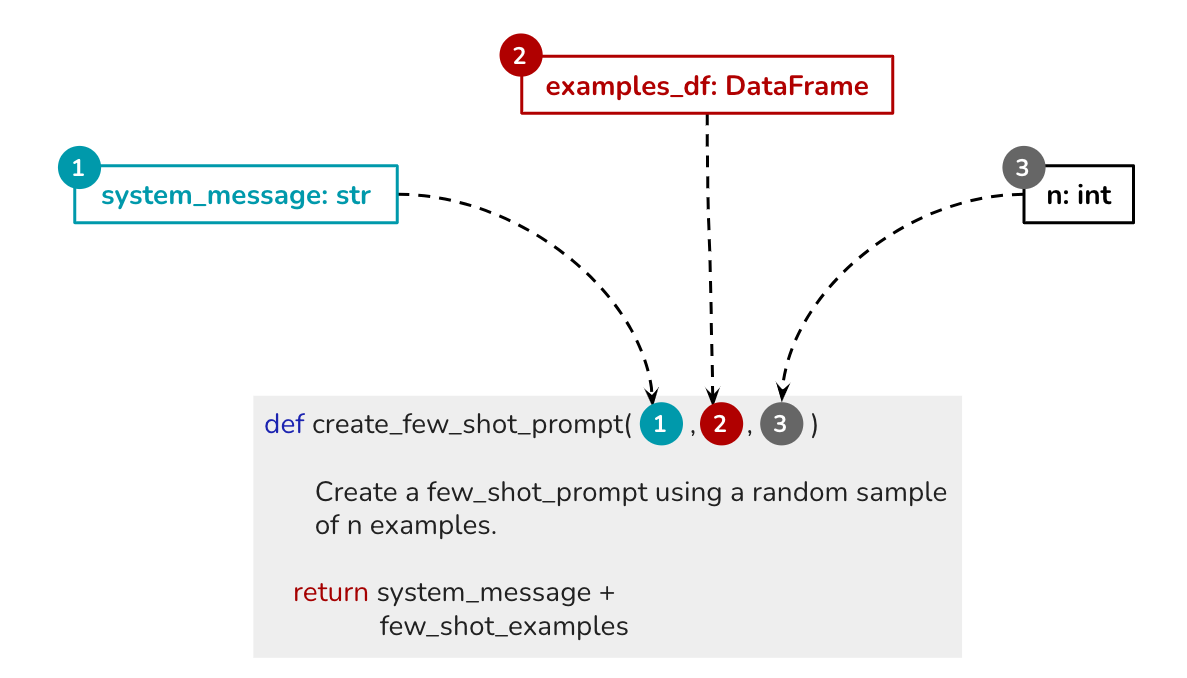

In [ ]:
def create_few_shot_prompt(system_message, examples_df, n=8):

    """
    Return a prompt message in the format expected by Mistral 7b.
    n examples (default 8) are selected randomly from training data to form the
    few-shot prompt.
    We then loop through each example and parse the dialogue as the user message
    and the summary as the assistant message.

    Args:
        system_message (str): system message with instructions for summarization
        examples_df (DataFrame): A DataFrame with examples (conversation + summary)
        n (int) = 8: number of examples of each class to be selected

    Output:
        few_shot_prompt (str): A prompt string in the Mistral format
    """

    few_shot_prompt = ''

    columns_to_select = ['dialogue', 'summary']

    examples = (
        examples_df.loc[:, columns_to_select]
                   .sample(n)
                   .to_json(orient='records')
    )

    for idx, example in enumerate(json.loads(examples)):
        user_input_example = example['dialogue']
        assistant_output_example = example['summary']

        if idx == 0:
            few_shot_prompt += mistral_first_turn_template.format(
                system_message=system_message,
                user_message=user_input_example,
                assistant_message=assistant_output_example
            )
        else:
            few_shot_prompt += mistral_examples_template.format(
                user_message=user_input_example,
                assistant_message=assistant_output_example
            )

    return few_shot_prompt

Each time this function is executed, a new set of examples is sampled and a prompt is created.

In [ ]:
few_shot_prompt = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

In [ ]:
print(few_shot_prompt)

<s>[INST]

Summarize the dialogue mentioned in the user input below. Be specific and concise in your summary.
The dialogue will be delimited by triple backticks, that is, ```.
```#Person1#: Come back. You haven't paid yet. 
#Person2#: May, just let him go. 
#Person1#: But he took some newspaper away without paying. 
#Person2#: I know. 
#Person1#: Why? You make me confused. 
#Person2#: He lives nearby and he would just glance at the newspaper headlines, read the political sections and return them later. 
#Person1#: Why does he have such a privilege? 
#Person2#: He used to be a hero during the war time and everyone respect him. 
#Person1#: I see. Does he live by himself? 
#Person2#: Yes, he has no children and his wife passed away when he was in the battle. 
#Person1#: He must be lonely? 
#Person2#: I bet. But he is always busy telling the children stories. 
#Person1#: How respectable! ```[/INST]#Person2# tells May that the man who took the newspaper without paying would return it and th

## Evaluate

We begin by collecting predictions on the gold examples.

In [ ]:
model_predictions, ground_truths = [], []

In [ ]:
for example in json.loads(gold_examples):
    gold_dialogue = example['dialogue']
    user_input = mistral_prediction_template.format(
            user_message=gold_dialogue,
            assistant_message=''
        )

    try:
        response = lcpp_llm(
            prompt=few_shot_prompt+user_input,
            max_tokens=128,
            temperature=0,
            top_p=0.95,
            repeat_penalty=1.2,
            echo=False # do not return the prompt
        )

        prediction = response["choices"][0]["text"]

        model_predictions.append(prediction)
        ground_truths.append(example['summary'])

    except Exception as e:
        print(e) # Log error and continue
        continue


llama_print_timings:        load time =     753.33 ms
llama_print_timings:      sample time =      33.25 ms /    54 runs   (    0.62 ms per token,  1624.06 tokens per second)
llama_print_timings: prompt eval time =    2620.54 ms /  2145 tokens (    1.22 ms per token,   818.53 tokens per second)
llama_print_timings:        eval time =    1629.34 ms /    53 runs   (   30.74 ms per token,    32.53 tokens per second)
llama_print_timings:       total time =    4480.81 ms /  2198 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     753.33 ms
llama_print_timings:      sample time =      22.59 ms /    41 runs   (    0.55 ms per token,  1815.04 tokens per second)
llama_print_timings: prompt eval time =     231.94 ms /   104 tokens (    2.23 ms per token,   448.40 tokens per second)
llama_print_timings:        eval time =    1225.73 ms /    40 runs   (   30.64 ms per token,    32.63 tokens per second)
llama_print_timings:       total time =    1596.76 ms /   144 

In [ ]:
len(model_predictions), len(ground_truths)

(50, 50)

In [ ]:
model_predictions[0], ground_truths[0]

('The insurance salesperson offers #Person2# more life insurance, emphasizing its importance in case of unexpected events. #Person2# expresses concern about her financial situation should anything happen to her husband and agrees to look at the policy offered by the salesperson.',
 "#Person1# recommends #Person2# to buy more life insurance. Even though #Person2#'s husband has some, those insurances can't cover both of them. #Person1#'ll show #Person2# the policy.")

### BLEU

In [ ]:
bleu_scorer = evaluate.load('bleu')

In [ ]:
bleu_scorer.compute(
    predictions=model_predictions,
    references=ground_truths
)

{'bleu': 0.0958276132474714,
 'precisions': [0.3232121454254894,
  0.1471667346106808,
  0.0744902205576363,
  0.02379940501487463],
 'brevity_penalty': 1.0,
 'length_ratio': 1.7050408719346049,
 'translation_length': 2503,
 'reference_length': 1468}

### ROUGE

In [ ]:
rouge_scorer = evaluate.load("rouge")

In [ ]:
rouge_scorer.compute(
    predictions=model_predictions,
    references=ground_truths
)

{'rouge1': 0.33846727956263883,
 'rouge2': 0.08895029075798946,
 'rougeL': 0.24637966000540734,
 'rougeLsum': 0.24581850648122444}

### BERTScore

In [ ]:
bert_scorer = evaluate.load("bertscore")

In [ ]:
bert_score = bert_scorer.compute(
    predictions=model_predictions,
    references=ground_truths,
    lang="en",
    rescale_with_baseline=True
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sum(bert_score['f1'])/len(bert_score['f1'])

0.4098417973518372

As we're conducting abstractive summarization, we employ BERTScore to assess the prompt's performance. With BERTScore typically falling between 0.3 and 0.5, our conclusion is that the prompt effectively produces a high-quality summary.

### Using Rater LLMs

In [ ]:
mistral_rating_template = "<s>[INST]{prompt}[/INST]"

In [ ]:
rater_system_message = """
You are tasked with rating AI-generated summaries of dialogues.
You will be presented a dialogue and an AI generated summary of the dialgoue as the input.
In the input, the dialogue will begin with ###Dialogue while the AI generated summary will begin with ###Summary.

Instructions:
1. Carefully observe the dialogue and its AI-generated summary presented in the input
2. Rate the quality of the summary generated by the AI system on a scale of 1 to 5, 1 being low quality and 5 being high quality.
Note that the AI system was asked to generate a concise summary reflecting the most important points mentioned in the dialogue.
In your rating, focus your assessment only on whether the summary was an accurate, concise reflection of key points in the dialogue.

Please do not explain your rating, the output should only be the rating between 1 to 5.
"""

In [ ]:
rater_user_message_template = """
###Dialogue
{dialogue}

###Summary
{summary}
"""

Let us see this rater in action on a specific gold example.

In [ ]:
gold_example = json.loads(gold_examples)[0]

In [ ]:
gold_example

{'dialogue': "#Person1#: Good afternoon Miss, would you be interested in buying more life insurance? You know, you can never get enough.\n#Person2#: I think my husband has some.\n#Person1#: Are you sure he ' s purchased enough insurance for both of you? If something terrible happened with your husband, and he doesn ' t have sufficient insurance, my company does have a policy that could cover you and your husband if something happened to either of you.\n#Person2#: That ' s true. If something happened to my husband, I might lose everything. Both of us have to work to keep our home, car, and our children ' s education. I can ' t afford that by myself.\n#Person1#: Could we sit and look at the policy I mentioned and see if that ' s something suitable for you and your husband?\n#Person2#: Certainly.",
 'summary': "#Person1# recommends #Person2# to buy more life insurance. Even though #Person2#'s husband has some, those insurances can't cover both of them. #Person1#'ll show #Person2# the poli

In [ ]:
model_predictions[0]

'The insurance salesperson offers #Person2# more life insurance, emphasizing its importance in case of unexpected events. #Person2# expresses concern about her financial situation should anything happen to her husband and agrees to look at the policy offered by the salesperson.'

In [ ]:
prompt = mistral_rating_template.format(
    prompt=rater_system_message+rater_user_message_template.format(
            dialogue=gold_example['dialogue'],
            summary=model_predictions[0]
        )
)

In [ ]:
print(prompt)

<s>[INST]
You are tasked with rating AI-generated summaries of dialogues.
You will be presented a dialogue and an AI generated summary of the dialgoue as the input.
In the input, the dialogue will begin with ###Dialogue while the AI generated summary will begin with ###Summary.

Instructions:
1. Carefully observe the dialogue and its AI-generated summary presented in the input
2. Rate the quality of the summary generated by the AI system on a scale of 1 to 5, 1 being low quality and 5 being high quality.
Note that the AI system was asked to generate a concise summary reflecting the most important points mentioned in the dialogue.
In your rating, focus your assessment only on whether the summary was an accurate, concise reflection of key points in the dialogue.

Please do not explain your rating, the output should only be the rating between 1 to 5.

###Dialogue
#Person1#: Good afternoon Miss, would you be interested in buying more life insurance? You know, you can never get enough.
#Per

In [ ]:
response = lcpp_llm(
    prompt=prompt,
    max_tokens=3,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit

llama_print_timings:        load time =     753.33 ms
llama_print_timings:      sample time =       1.78 ms /     3 runs   (    0.59 ms per token,  1689.19 tokens per second)
llama_print_timings: prompt eval time =     661.74 ms /   454 tokens (    1.46 ms per token,   686.07 tokens per second)
llama_print_timings:        eval time =      58.91 ms /     2 runs   (   29.45 ms per token,    33.95 tokens per second)
llama_print_timings:       total time =     732.72 ms /   456 tokens


In [ ]:
prediction = response["choices"][0]["text"].strip().replace(".", "")

In [ ]:
prediction

'5'

This rater can now be used to roll out ratings to all the summaries generated by the LLM.